# Machine Learning: Basic Principles 2018
# Clustering

Organize a large number of data points into coherent groups (clusters) using clustering methods using:
- the hard clustering method __k-means__
- soft clustering method which is motivated by probabilistic __Gaussian mixture models__.

On a high level, clustering is the task of dividing a (unlabeled) dataset $\mathbf{X} = \{ \mathbf{x}^{(i)} \}_{i=1}^{N}$, with $N$ data points $\mathbf{x}^{(i)} \in \mathbb{R}^{d}$, into a small number of groups or "clusters" $\mathcal{C}_{1},\ldots,\mathcal{C}_{k}$. 

Each cluster represents a subset of data points such that data points belonging to the same cluster are more similar to each other than to data points from another cluster. 

In contrast to regression and classification problems considered in earlier exercises, clustering methods do not require labeled data and can be applied to datasets whose data points $\mathbf{z}^{(i)}$ are characterized solely by its features $\mathbf{x}^{(i)}$. 

Therefore clustering methods are referred to as **unsupervised** machine learning methods.

There are two main flavors of clustering methods: 
* __hard clustering methods__  - assign each data point to one and only one cluster.

* __soft clustering methods__ - soft-clustering methods assign each data point to several different clusters with varying probabilities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
from ipywidgets import IntProgress

## Choosing nice colors for plot
#if you want to plot for k>3, extend these lists of colors
cmpd = ['orangered','dodgerblue','springgreen']

In [2]:
#read in data from the csv file
df = pd.read_csv("data.csv")
data=df.values

#display first 5 rows, to get a feeling for the data
display(df.head(5))
print(data.shape)

,Age,Spending
0,28.018868,5.263333
1,27.897623,5.276452
2,29.042011,4.794357
3,29.669165,5.207227
4,29.494291,6.351539


(400, 2)


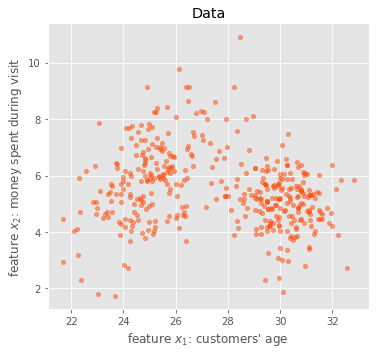

In [3]:
def plotting(data, centroids=None, clusters=None):
    #this function will later on be used for plotting the clusters and centroids. But now we use it to just make a scatter plot of the data
    #Input: the data as an array, cluster means (centroids), cluster assignemnts in {0,1,...,k-1}   
    #Output: a scatter plot of the data in the clusters with cluster means
    plt.figure(figsize=(5.75,5.25))
    plt.style.use('ggplot')
    plt.title("Data")
    plt.xlabel("feature $x_1$: customers' age")
    plt.ylabel("feature $x_2$: money spent during visit")

    alp = 0.5             #data alpha
    dt_sz = 20            #data point size
    cent_sz = 130         #centroid sz
    
    if centroids is None and clusters is None:
        plt.scatter(data[:,0], data[:,1],s=dt_sz,alpha=alp ,c=cmpd[0])
    if centroids is not None and clusters is None:
        plt.scatter(data[:,0], data[:,1],s=dt_sz,alpha=alp, c=cmpd[0])
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", s=cent_sz, c=cmpcent)
    if centroids is not None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[cmpd[i] for i in clusters], s=dt_sz, alpha=alp)
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", c=cmpcent, s=cent_sz)
    if centroids is None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[cmpd[i] for i in clusters], s=dt_sz, alpha=alp)
    
    plt.show()

#plot the data
plotting(data)   

## 3. Exercise
The actual exercise starts from here and it has been divided in 3 tasks:
* 3.1 **Hard clustering with k-means** 
* 3.2 **Handling local minima with k-means**
* 3.3 **Soft clustering with Gaussian mixture models (GMMs)**

## 3.1 Hard clustering with k-means
<a id="kmeans"></a>

A popular method for hard clustering is the k-means algorithm which takes as input a list of data points $\mathbf{x}^{(1)},...,\mathbf{x}^{(N)} \in \mathbb{R}^{d}$ and groups them into $k$ non-overlapping clusters $\mathcal{C}_{¡},\ldots,\mathcal{C}_{k}$. Each cluster $\mathcal{C}_{c}$ is characterized by its cluster mean $\mathbf{m}^{(c)} \in \mathbb{R}^{d}$. As a hard-clustering method, k-means assigns each data point $\mathbf{x}^{(i)}$ to exactly one cluster whose index we denote as $y^{(i)} \in 1,...,k$. We can interpret the cluster assignments $y^{(i)}$ as (hidden) labels of the data points. However, we do not have access to the cluster assignment of any data point but rather have to estimate them based on the internal or intrinsic structure of the data set $\mathbf{x}^
{(1)}, \ldots, \mathbf{x}^{(N)}$.


K-means can be summarized as follows:

* Choose initial cluster means $ \mathbf{m}^{(1)},...,\mathbf{m}^{(k)}$

* Repeat until stopping condition is reached:  

    * Assign each datapoint to the cluster whose mean is nearest. 
    
    I.e. for all $i=1,...,N$, do  $$ y^{(i)} = \underset{c'}{\operatorname{argmin}} \|\mathbf{x}^{(i)} - \mathbf{m}^{(c')}\|^2 $$
    
    * Update the new cluster means by calculating the average of the points in the cluster. 
    
    I.e. for all $c=1,...,k$, set 
    \begin{equation*}
    \mathbf{m}^{(c)} = \frac{1}{\mid\{i: y^{(i)}= c\}\mid}{\sum_{i: y^{(i)}= c}\mathbf{x}^{(i)}}     \label{mean}
    \tag{1}
    \end{equation*}
    where $\{i: y^{(i)}= c\}$ represents the set of datapoints belonging to cluster c and $\mid\{i: y^{(i)}= c\}\mid$ the number of datapoints belonging to cluster c.  
    
    Note: Do this only for the clusters with at least one member, those with no members keep the old mean. 


Thus, k-means consists of 4 simple steps:

* __Step 1 - Initialize cluster means.__
* __Step 2 - Update the cluster assignments: assign datapoints to the nearest cluster means.__
* __Step 3 - Update the cluster means by computing the mean (average) of the data points assigned to a particular cluster.__
* __Step 4 - If not finished go to step 2.__

The working of $k$-means is best understood by walking through an example. To this end, we apply $k$-means to the Café customer data. 


### Step 1: Initialize cluster means

We first initialize the cluster means, also called centroids. The most common way is to do this by randomly choosing points between the minimum and maximum values of the data. However, here we select predefined data points, in order to have no randomness. 

In [4]:
def select_centroids(data, k, random_seed=1): 
    """
    data: N x d data array 
    k: number of clusters
    
    Returns
        k x d array of k randomly assigned mean vectors with d dimensions.
    """
    # Random seed will generate exactly same "random" values for each execution.
    np.random.seed(seed=random_seed)
    
    n_features = data.shape[1]
    centroids = np.zeros((k, n_features))
    for i in range(n_features):

        centroids[:,i] = np.random.uniform(np.min(data[:,i]), 
                                           np.max(data[:,i]), 
                                           size = (k))
    return centroids

[[26.32009513  1.74924226]
 [29.7021882   4.52106838]]


NameError: name 'cmpcent' is not defined

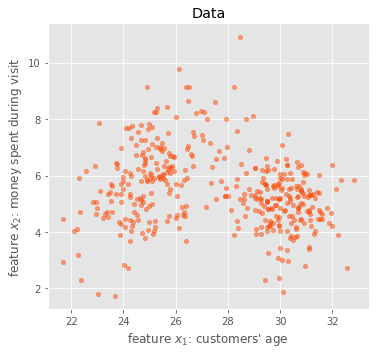

In [5]:
centroids = select_centroids(data=data, k=2)
print(centroids)
# each col is feature, 
# each row is a centroid
plotting(data, centroids)

### Step 2: Cluster assignment update: Assign each datapoint to the cluster of nearest cluster mean

In this step your task is to assign each data point $\mathbf{x}^{(i)}$ to the cluster $c$ with the nearest cluster mean $\mathbf{m}^{(c)}$. This distance is measured by the Euclidean distance $\| \mathbf{x}^{(i)} - \mathbf{m}^{(c)} \|$. This will result in a vector of length $N$ whose entries are the cluster assignments $y^{(i)}$ for each point.

#### Tasks
- Implement a Python function `assign_points()` which takes as inputs the data and centroids (cluster means). It should return a vector, named _clusters_, whose entries are the cluster assignments $y^{(i)}$ for each point. 
    - You can use `np.linalg.norm()` to get the Euclidean distance. 
    - You can use `np.argmin()` to get the indices of the minimum values along an axis in an array.
    - Note: Remember that indexing in Python starts from 0, hence it might be easier to number the clusters from 0...k-1, but it is up to you to decide :)  

In [ ]:
print(centroids)
print(centroids.shape)

In [ ]:
def assign_points(data, centroids):
    """
    data: N x d data
    centroids: k x d
    
    Returns:
        N x 1 array of cluster assignments in {0,...,k-1}.    
    """
    N, d = data.shape
    clusters = np.zeros(N,dtype=np.int32)
    
    for i in range(N):
        point = data[i]
        minDistance = np.float('inf')
        current_centroid = 0
        
        for c_ix in range(len(centroids)):
            cent = centroids[c_ix]
            distance = np.sqrt(np.sum(np.power(np.subtract(point, cent), 2)))
            if distance < minDistance:
                minDistance = distance
                current_centroid = c_ix
                
        clusters[i] = current_centroid
    return clusters

In [ ]:
clusters = assign_points(data, centroids)
plotting(data, centroids, clusters)

### Step 3: update cluster means

We now want to update the cluster means $\mathbf{m}^{(c)}$ of the data points that were assigned to cluster c during the previous step.

In [ ]:
c1 = [data[i] for i in range(len(clusters)) if clusters[i] == 0]
c2 = [data[i] for i in range(len(clusters)) if clusters[i] == 1]
plt.scatter(*np.transpose(c1),c="r")
plt.scatter(*np.transpose(c2),c="b")
plt.scatter(*np.mean(c1, axis=0), marker="x")

- Implement the Python function `move_centroids()` which takes as input the data, old centroids and cluster assignments. It should return the new centroids. 
    - You can use `np.mean()` to compute the mean (see Eq. (1)) of all points belonging to one cluster. 
    - You need to keep in mind that there might be a situation when none of the points were assigned to a cluster. If this is the case, you should assign the old centroid as new centroid.

In [ ]:
clusters[250:270]

In [ ]:
def move_centroids(data, old_centroids, clusters):
    """
    data array: N x d
    old_centroids array: k x d 
    clusters: N x 1
    
    Returns
        k x d array of relocated centroids
    """    
    new_centroids = np.zeros(old_centroids.shape)
    N, d = data.shape
    k, _ = centroids.shape
    
    for c_ix in range(k):
        cluster_of_points = [data[i] for i in range(N) if clusters[i] == c_ix]
        cluster_mean = np.mean(cluster_of_points, axis=0)
        new_centroids[c_ix] = cluster_mean
    
    return new_centroids

In [ ]:
move_centroids(data, centroids,clusters)

In [ ]:
new_centroids = move_centroids(data, centroids,clusters)
plotting(data, new_centroids, clusters)

In [ ]:
k = 3

centroids = select_centroids(data, k, random_seed=1) 

print(centroids)

clusters = assign_points(data, centroids)

print(f'Clusters {np.unique(clusters)}')

plotting(data, centroids, clusters)

In [ ]:
k = 3

centroids = select_centroids(data, k, random_seed=1) 

print(centroids)

clusters = assign_points(data, centroids)

for _ in range(10):
    new_centroids = move_centroids(data, centroids,clusters)
    new_clusters = assign_points(data, new_centroids)
    plotting(data, new_centroids, new_clusters)
    
print(new_centroids)

In [ ]:
k = 3
random_seed = 1
data = data
plot = True
num_iters = 10

centroids = select_centroids(data, k, random_seed) 
for i in range(num_iters):
    clusters = assign_points(data, centroids)
    #plotting
    if plot==True:
        plotting(data,centroids,clusters)

    centroids = move_centroids(data, centroids,clusters)
    
print(centroids)

In [ ]:
def k_means(data, k, random_seed=1, num_iters=10,plot=True):
    """
    #INPUT: 
    N x d data array, 
    k number of clusters, 
    number of iterations, 
    boolean plot.
    
    Returns
        N x 1 array of cluster assignments.     
    """
    centroids = select_centroids(data, k, random_seed) 
    for i in range(num_iters):
        clusters = assign_points(data, centroids)
        #plotting
        if plot==True and i<3:
            plotting(data,centroids,clusters)

        centroids = move_centroids(data, centroids,clusters)

    return centroids, clusters


centroids,clusters = k_means(data, 3)
print("The final cluster mean values are:",centroids)

## 3.2. Handling local minima in k-means
<a id="local"></a>

As introduced in the course book, the k-means algorithm aims at minimizing the __empirical risk__: 

$$\mathcal{E}  ( \{\mathbf{m}^{(c)}\}_{c=1}^{k},\{y^{(i)}\}_{i=1}^{N} \mid \{\mathbf{x}^{(i)}\}_{i=1}^{N} )
=\frac{1}{N} \sum_{i=1}^{N} {\left\|\mathbf{x}^{(i)}-\mathbf{m}^{(y^{(i)})}\right\|^2}
$$

Since the empirical risk is a highly non-convex function of the cluster means and assignments, the k-means method will sometimes get trapped in a local minimum.

It is therefore useful to run k-means several times with different initializations for the cluster means and choose the cluster assignment that yields the smallest empirical risk. 

In [ ]:
def empirical_risk(data, clusters, centroids):   
    #INPUT: N x d data array, k x d array of k mean vectors (centroids),  
    #       N x 1 array of cluster assignments. 
    #OUTPUT: value of empirical risk 
     
    ### STUDENT TASK ### 
    # YOUR CODE HERE 
    count_0=0 
    count_1=0 
    count_2=0 
    for i in range (data.shape[0]): 
        if clusters[i]==0: 
            count_0=count_0+1 
        if clusters[i]==1: 
            count_1=count_1+1 
        count_2=data.shape[0]-count_0-count_1 
    cluster_0=np.zeros((count_0,2)) 
    cluster_1=np.zeros((count_1,2)) 
    cluster_2=np.zeros((count_2,2)) 
    n=0 
    m=0 
    l=0 
    for i in range (data.shape[0]): 
        if clusters[i]==0: 
            cluster_0[n,:]=data[i,:] 
            n=n+1 
        if clusters[i]==1: 
            cluster_1[m,:]=data[i,:] 
            m=m+1 
        if clusters[i]==2: 
            cluster_2[l,:]=data[i,:] 
            l=l+1 
    #risk=0 
    #for i in range (cluster_0.shape[0]): 
    #    risk=risk+np.sqrt(pow(centroids[0,0]-cluster_0[i,0],2)+pow(centroids[0,1]-cluster_0[i,1],2)) 
    #for i in range (cluster_1.shape[0]): 
    #    risk=risk+np.sqrt(pow(centroids[1,0]-cluster_1[i,0],2)+pow(centroids[1,1]-cluster_1[i,1],2)) 
    #for i in range (cluster_2.shape[0]): 
     #   risk=risk+np.sqrt(pow(centroids[2,0]-cluster_2[i,0],2)+pow(centroids[2,1]-cluster_2[i,1],2)) 
         
     
    risk = pow(np.linalg.norm(cluster_0 - centroids[0,:]),2) 
    risk += pow(np.linalg.norm(cluster_1 - centroids[1,:]),2) 
    risk += pow(np.linalg.norm(cluster_2 - centroids[2,:]),2) 
    risk=risk/data.shape[0] 
     
    return risk 

In [ ]:
def new_k_means(data, k, plot=True):  
    # This will display a progress bar during k-mean execution
    f = IntProgress(description=f'KM (k={k}):',min=0, max=50)
    display(f)
    
    # initializing the array where we collect all cluster assignments  
    cluster_collection = np.zeros((50, data.shape[0]),dtype=np.int32)
    # initializing the array where we collect all risk values 
    risk_collection = np.zeros(50)
    
    for i in range(50):
        f.value +=1
        centroids,clusters=k_means(data,k,random_seed=i,plot=False)
        risk_collection[i] = empirical_risk(data, clusters, centroids)
        cluster_collection[i,:] = clusters
        
    #find the best cluster assignment and print the lowest found empirical risk
    min_ind = np.argmin(risk_collection)
    max_ind=np.argmax(risk_collection)
    if plot==True:
        print("Cluster division with lowest empirical risk")
        plotting(data,clusters=cluster_collection[min_ind,:])
        print("Cluster division with highest empirical risk")
        plotting(data,clusters=cluster_collection[max_ind,:])
    
        print('min empirical risk is ', np.min(risk_collection))
    
    #Let's remove progress bar
    f.close()
    return cluster_collection[min_ind,:],risk_collection

In [ ]:
best_cluster,risk=new_k_means(data,3)